In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
import copy
import pickle

In [11]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

In [2]:
train_full = pd.read_csv("./data/base/train-white.csv", sep=",")
test_full = pd.read_csv("./data/base/test-white.csv", sep=",")

In [3]:
target = "quality"
model_name = "rf"

In [4]:
with open('./model/prepared-{}.pickle'.format(model_name), 'rb') as f:
    model = pickle.load(f)

In [5]:
X_train = copy.deepcopy(train_full.drop(columns=target))
X_test = copy.deepcopy(test_full.drop(columns=target))
y_train = train_full[target]
y_test = test_full[target]

In [42]:
from pymongo import MongoClient
from bson.objectid import ObjectId

In [64]:
# Create a MongoClient to the running mongod instance
client = MongoClient("localhost", 27017)

# Get a reference to a particular database
db = client["pipeline"]
pd_meta_collection = db["pd_meta"]
partial_dependence_collection = db["partial_dependence_collection"]
ice_collection = db["ice_collection"]
pd_values_collection = db["pd_values_collection"]


In [44]:
pd_meta_collection.insert_one(
    {
        "model_id": ObjectId("64a3dd58a59f6ff712b0909d"),
        "data_id": ObjectId("649ee7d8ff2ad88d84cdd9fe"),
    }
)

In [60]:
pd_meta_collection.insert_one(
    {
        "model_id": ObjectId("64a3dd58a59f6ff712b0909d"),
        "data_id": ObjectId("649ee7d8ff2ad88d84cdd9ff"),
    }
)

In [66]:
pd_meta_ID_train = pd_meta_collection.find_one(
    {"model_id": ObjectId("64a3dd58a59f6ff712b0909d"), "data_id": ObjectId("649ee7d8ff2ad88d84cdd9fe")}
)["_id"]

In [67]:
pd_meta_ID_test = pd_meta_collection.find_one(
    {"model_id": ObjectId("64a3dd58a59f6ff712b0909d"), "data_id": ObjectId("649ee7d8ff2ad88d84cdd9ff")}
)["_id"]

In [68]:
for index, feature in enumerate(X_train.columns):
    pdp = partial_dependence(model, X_train, [index], kind="both")
    for cl_index, cl in enumerate(model[model_name].classes_):
        partial_dependence_collection.insert_one(
            {
                "pd_meta_ID": pd_meta_ID_train,
                "feature": feature,
                "class": int(cl),
                "average": pdp["average"][cl_index].tolist()
            }
        )
        pd_values_collection.insert_one(
            {
                "pd_meta_ID": pd_meta_ID_train,
                "feature": feature,
                "class": int(cl),
                "values": pdp["values"][0].tolist()
            }
        )
        # for elem_ind, elem in enumerate(pdp["individual"][cl_index]):
        #     ice_collection.insert_one(
        #         {
        #             "pd_meta_ID": pd_meta_ID,
        #             "feature": feature,
        #             "class": int(cl),
        #             "index": elem_ind,
        #             "individual": elem.tolist()
        #         }
        #     )

In [69]:
for index, feature in enumerate(X_test.columns):
    pdp = partial_dependence(model, X_test, [index], kind="both")
    for cl_index, cl in enumerate(model[model_name].classes_):
        partial_dependence_collection.insert_one(
            {
                "pd_meta_ID": pd_meta_ID_test,
                "feature": feature,
                "class": int(cl),
                "average": pdp["average"][cl_index].tolist()
            }
        )
        pd_values_collection.insert_one(
            {
                "pd_meta_ID": pd_meta_ID_test,
                "feature": feature,
                "class": int(cl),
                "values": pdp["values"][0].tolist()
            }
        )
        for elem_ind, elem in enumerate(pdp["individual"][cl_index]):
            ice_collection.insert_one(
                {
                    "pd_meta_ID": pd_meta_ID_test,
                    "feature": feature,
                    "class": int(cl),
                    "index": elem_ind,
                    "individual": elem.tolist()
                }
            )

In [35]:
pdp = partial_dependence(model, X_train, [0], kind="both")

In [16]:
model.classes_

array([3, 4, 5, 6, 7, 8, 9], dtype=int64)

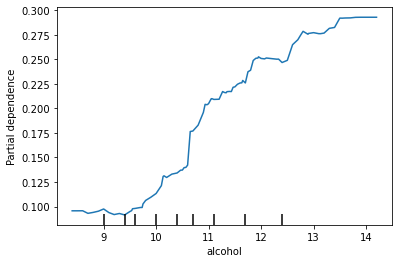

In [34]:
PartialDependenceDisplay.from_estimator(model, X_train, [X_train.columns[-1]], target=7)

In [59]:
pdp["individual"][0].shape

(3428, 65)

ValueError: x and y must have same first dimension, but have shapes (100,) and (3428, 100)

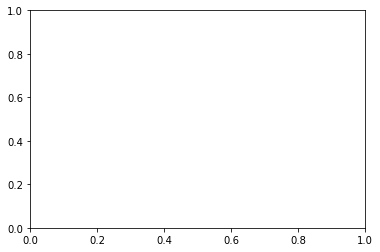

In [28]:
plt.plot(pdp["values"][0], pdp["average"][1])